# Training

This notebook loads the ETL data and trains the LSTM. 

In [1]:
%load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
x_train = xr.load_dataarray("../data/etl/x_train.nc")
x_val = xr.load_dataarray("../data/etl/x_val.nc")
y_train = xr.load_dataarray("../data/etl/y_train.nc")
y_val = xr.load_dataarray("../data/etl/y_val.nc")

In [4]:
xdims = dict(zip(x_train.dims, x_train.shape))
ydims = dict(zip(y_train.dims, y_train.shape))
print(xdims, ydims)

{'samples': 274136, 'lookback': 90, 'features': 6} {'samples': 274136, 'features': 4}


In [12]:
backend.sum

<function tensorflow.python.keras.backend.sum(x, axis=None, keepdims=False)>

In [13]:
input_shape = (xdims["lookback"], xdims["features"])
print(input_shape)


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    return backend.mean(backend.square(y_pred - y_true), axis=-1)


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res = backend.sum(backend.square(y_true - y_pred))
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + backend.epsilon())


def bias(y_true, y_pred):
    return backend.mean(y_pred) - backend.mean(y_true)


metrics = [rmse, mse, r_square, bias]


def make_model_1():
    # design network
    name = "1_layer_lstm"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_2():
    # design network
    name = "2_layer_lstm"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_3():
    # design network
    name = "3_layer_lstm"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model


def make_model_4():
    # design network
    name = "3_layer_lstm_wide"
    model = Sequential(name=name)
    model.add(LSTM(40, input_shape=input_shape, use_bias=True, return_sequences=True))
    model.add(LSTM(40, return_sequences=True))
    model.add(LSTM(40))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=metrics)
    return model

(90, 6)


In [6]:
# train the model
# history = {}
# for batch_size in [128, 512, 2048, 8192, 16384]:
#     model = make_model_1()
#     history[batch_size] = model.fit(x_train.values, y_train.values,
#                         validation_data=(x_val.values, y_val.values),
#                          batch_size=batch_size, epochs=30,
#                          shuffle=True, callbacks=callbacks)

# plt.figure(figsize=(12, 12))
# # plot training history
# for batch, h in history.items():
# #     plt.plot(h.history['loss'], label=f'train-{batch}')
#     plt.plot(h.history['val_loss'], label=f'test-{batch}')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

# based on this, I'm using the batch_size of 512 for now

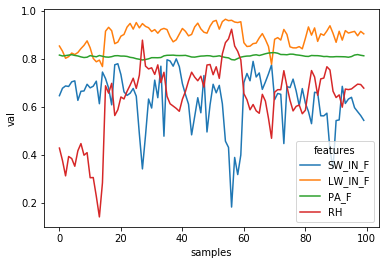

In [8]:
y_val[:100].plot.line(x="samples")

In [28]:
batch_size = 512
history = {}


def make_callbacks(name):
    mc = ModelCheckpoint(
        f"best_{name}.h5",
        monitor="val_mse",
        mode="max",
        verbose=0,
        save_best_only=True,
    )
    es = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=20)
    return [es, mc]


for model in [make_model_1(), make_model_2(), make_model_3(), make_model_4()]:
    # for model in [make_model_1()]:
    model.summary()
    history[model.name] = model.fit(
        x_train.values,
        y_train.values,
        validation_data=(x_val.values, y_val.values,),
        batch_size=batch_size,
        epochs=500,
        shuffle=True,
        callbacks=make_callbacks(model.name),
    )

Model: "1_layer_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 84        
Total params: 2,244
Trainable params: 2,244
Non-trainable params: 0
_________________________________________________________________
Train on 274136 samples, validate on 63528 samples
Epoch 1/500
274136/274136 [==============================] - 7s 24us/sample - loss: 0.0309 - rmse: 0.1356 - mse: 0.0309 - r_square: 0.4321 - bias: -0.0278 - val_loss: 0.0116 - val_rmse: 0.0970 - val_mse: 0.0116 - val_r_square: 0.7795 - val_bias: -0.0022
Epoch 2/500
274136/274136 [==============================] - 5s 20us/sample - loss: 0.0101 - rmse: 0.0897 - mse: 0.0101 - r_square: 0.8149 - bias: 1.4936e-04 - val_loss: 0.0097 - val_rmse: 0.0878 - val_mse: 0.

1_layer_lstm val_loss 0.011551865516916553
1_layer_lstm val_loss 0.0112838708526918
1_layer_lstm val_loss 0.012467817823825849
1_layer_lstm val_loss 0.01047015561527651
1_layer_lstm val_rmse 0.09696043
1_layer_lstm val_rmse 0.09551043
1_layer_lstm val_rmse 0.1006796
1_layer_lstm val_rmse 0.09241256
1_layer_lstm val_mse 0.011551866
1_layer_lstm val_mse 0.011283869
1_layer_lstm val_mse 0.012467818
1_layer_lstm val_mse 0.01047015
1_layer_lstm val_r_square 0.85732704
1_layer_lstm val_r_square 0.85730773
1_layer_lstm val_r_square 0.860679
1_layer_lstm val_r_square 0.8629133
1_layer_lstm val_bias 0.013421224
1_layer_lstm val_bias 0.01530196
1_layer_lstm val_bias 0.012775827
1_layer_lstm val_bias 0.012300842


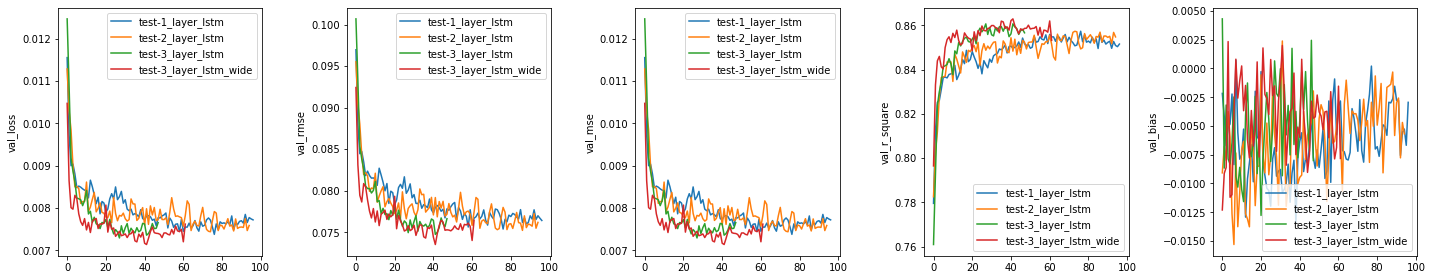

In [29]:
hvars = ["val_loss", "val_rmse", "val_mse", "val_r_square", "val_bias"]

fig, axes = plt.subplots(ncols=len(hvars), nrows=1, figsize=(20, 4))
for var, ax in zip(hvars, axes):
    plt.sca(ax)
    # plot training history
    for model, h in history.items():
        #     plt.plot(h.history['loss'], label=f'train-{batch}')
        plt.plot(h.history[var], label=f"test-{model}")
        print(batch, var, np.max(np.abs(h.history[var])))
    plt.ylabel(var)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.legend()
plt.tight_layout()